# Metrics and graphs

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pprint as pprint
import math
import time

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import os
import json
import pickle
import sklearn
from sklearn import neighbors

In [4]:
import import_ipynb

import Process_Training_Data_2

from Process_Training_Data_2 import norm
from Process_Training_Data_2 import denorm
from Process_Training_Data_2 import class_to_action
from Process_Training_Data_2 import closest_category
from Process_Training_Data_2 import extend_dataset
from Process_Training_Data_2 import normalize_data
from Process_Training_Data_2 import print_model_df_analysis
from Process_Training_Data_2 import group_by_path
from Process_Training_Data_2 import get_mean_error
from Process_Training_Data_2 import add_end_state

importing Jupyter notebook from Process_Training_Data_2.ipynb


### Get the data
First Import it using pandas

In [12]:
file = "OSPA_training_data.csv"

In [13]:
STEPS=8

dataset = Process_Training_Data_2.get_data("./data/"+file)

dataset_distances= dataset[["id_camino","D0",'D1',"D2","D3",'D4',"D5","A0","A1"]]

#exteneded_dataset = Process_Training_Data_2.extend_dataset(dataset_short,N_STEPS)
exteneded_dataset= add_end_state(dataset_distances)

action_vector = ["A0","A1"]
normed_dataset, data_stats = Process_Training_Data_2.normalize_data(exteneded_dataset, action_vector)

position = "post"
dataset2 = Process_Training_Data_2.padding(normed_dataset,STEPS,position)

#dataset2 = group_by_path(normed_dataset)

SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [14]:
Zero_Target= [0,0,0,0,0,0]
ZT_norm = norm(Zero_Target, data_stats)
ZT_norm 

NameError: name 'data_stats' is not defined

### Split the data into train and test

Now split the dataset into a training set and a test set.

We take the first TRAIN_SPLIT values as train data

We will use the test set in the final evaluation of our model.

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [8]:
def multivariate_data(dataset, target, start_index, end_index):
  data = []
  labels = []

  if end_index is None:
    end_index = len(dataset)

  for i in range(start_index, end_index):
    indices = range(0, len(dataset[i])-1)
    data.append(dataset[i,indices,:])

    labels.append(target[i, 1:])   

  return np.array(data), np.array(labels)

## single step model using sequential output
Given a sequence of actions, the model should predict the same sequency one step in the future

### Split features from labels

In [9]:
np.random.shuffle(dataset2)

In [10]:
TRAIN_SPLIT = int(len(dataset2)*0.8)
features_dataset = dataset2[:,:,:6]
target_dataset = dataset2[:,0:,:6]

x_train_single_sequential, y_train_single_sequential = multivariate_data(features_dataset, target_dataset,0, TRAIN_SPLIT)

x_val_single_sequential, y_val_single_sequential = multivariate_data(features_dataset, target_dataset, TRAIN_SPLIT, None)

In [11]:
BATCH_SIZE = 1
# BUFFER_SIZE = 10000

train_data_single_sequential = tf.data.Dataset.from_tensor_slices((x_train_single_sequential, y_train_single_sequential))
train_data_single_sequential = train_data_single_sequential.cache().batch(BATCH_SIZE).repeat()

val_data_single_sequential = tf.data.Dataset.from_tensor_slices((x_val_single_sequential, y_val_single_sequential))
val_data_single_sequential = val_data_single_sequential.batch(BATCH_SIZE).repeat()

In [16]:
N_CATEGORIES = 28
X = pd.DataFrame(columns=["A0", "A1"], dtype=np.float64, index=range(N_CATEGORIES))

for i in range(N_CATEGORIES):
    X["A0"][i] = class_to_action(str(i))[0]
    X["A1"][i] = class_to_action(str(i))[1]


In [62]:
model = tf.keras.models.load_model("./data/S2S_S2S_model_"+file+".h5")

In [65]:
def distance_error(x, z):
    distancia = math.sqrt(x**2 + z**2)
    return distancia

In [ ]:
def generate_trajectory(model, start, target, initial_action, data_stats):
  # Evaluation step (generating trajectory using the learned model)
  # start(9), target(9)

  # Number of points to generate
  num_generate = 20

  # time step used in the action
  time_step = 12/tc
  
  # Get Flight status target
  FS_target = FlightState.order_as_input(target[0:6],0,0)
  
  # Get Flight status start
  FS_start = FlightState.order_as_input(start[0:6],initial_action[0], initial_action[1])
  FS_current_state = FS_start

  # Compute the initial distance
  distance_long = target - start

  # normalize and add the action to get the Neuronal Network input
  distance = norm(distance_long, data_stats)
  input_eval = tf.expand_dims([distance], 0)
  

  # Empty vector to store the actions
  trajectory_generated = []

  # Empty vector to store the actions
  actions = []

  # First point is the initial distance
  trajectory_generated.append(distance)

  # initialize cost
  cost = 0

  #initialize distance error
  distancia_error = distance_error(*distance_long[0:2])

  #initialize action vector
  actions.append(initial_action)

  # Here batch size == 1 and sequence size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)

      last_action = predictions[:,-1,:]
      # remove the batch dimension
      action = tf.squeeze(last_action, 0)
      
      actions.append(np.array(action))

      #Expand the action vector with the time step
      action_long = np.append(action, time_step)

      # new_state, boolean = get_next_state(current_state(9), action(2), target_state(6))
      FS_new_state, boolean = get_next_state(FS_current_state, action_long,  FS_target)

      if boolean > 0:

        # We pass the predicted point as the next input to the model
        # along with the previous hidden state
        FS_current_state = FS_new_state
        current_state= FS_current_state.get_info_formatted()
        distance_long = target - current_state[0:6]

        distance = norm(distance_long, data_stats)
  
        trajectory_generated.append(distance)

        input_eval = tf.expand_dims(np.array(trajectory_generated),0)
        cost = current_state[8]

        #Error distancia = raiz(x, z, pitch, velocidad) de la suma de los cuadrados de las que estan dentro. La velocidad es... velocidad = raiz(u**2 + v**2)
        distancia_error = distance_error(*distance_long[0:2])

      elif boolean == 0:
        print("End")
        end_message = "End"
        break

      else:
        print("Error")
        end_message = "Error"
        break 

  trajectory_generated_denorm = np.apply_along_axis(denorm,1,
        trajectory_generated,data_stats)    

  return trajectory_generated_denorm, cost, distancia_error, actions, end_message

In [79]:
def get_trajectory_results(x_single_sequential, y_single_sequential, data_stats):
    results = pd.DataFrame(columns = ["path", "actions", "distance", "cost", "mean_distance","end_message"])

    for t_number in range(len(y_single_sequential)):

        x_denorm = np.apply_along_axis(denorm,1,x_single_sequential[t_number],data_stats)

        y_denorm = np.apply_along_axis(denorm,1,y_single_sequential[t_number],data_stats)

        initial_action = [0,0]
        start = [0.0, 0.0, 4.257165346815115, 0.0, 0, 0]
        target = x_denorm[0] + start

        start_time = time.time()

        trajectory, cost, actions, end_message = generate_trajectory_Decoder(model, start, target, initial_action, data_stats)

        t_time = time.time() - start_time

        pred_trajectory_states = target - trajectory
        OSPA_trajectory_states =  target - y_denorm
        OSPA_trajectory_states=np.insert(OSPA_trajectory_states,0,start, axis=0)

        min_len = min(len(y_denorm),len(trajectory[1:]))

        mse =sklearn.metrics.mean_squared_error(OSPA_trajectory_states[0:min_len,0:2], pred_trajectory_states[0:min_len,0:2])

        results.at[t_number, "time"] = t_time
        results.at[t_number, "actions"] = np.array(actions)
        results.at[t_number, "path"] = np.array(trajectory)
        results.at[t_number, "sqrt(trajectory MSE)"] = math.sqrt(mse)
        results.at[t_number, "cost"] = cost
        results.at[t_number, 'distance_to_target'] = distance_error(*trajectory[-1,0:2])
        results.at[t_number, 'end_message'] = end_message
        results.at[t_number, "mean_distance_in_trajectory"] = get_mean_error(OSPA_trajectory_states, pred_trajectory_states, num=10, eps = 5)
        results.at[t_number, "k_value"] = abs(target[1])/abs(target[0])
        results.at[t_number, "u_at_target"] = pred_trajectory_states[-1,2]
        results.at[t_number, "v_at_target"] =distance_error(pred_trajectory_states[-1,2], pred_trajectory_states[-1,3])
        results.at[t_number, "theta_at_target"] = pred_trajectory_states[-1,4]
        "u_at_target"

    return results


In [67]:
def get_trajectory_results_2(trajectoty_list, data_stats):
    results = pd.DataFrame(columns = ["path", "actions", "distance", "cost", "mean_distance","end_message"])

    for t_number in range(len(trajectoty_list)):

        initial_action = [0,0]
        start = trajectoty_list[t_number][0,-2]
        target = trajectoty_list[t_number][0,-1]

        start_time = time.time()

        trajectory, cost, actions, end_message = generate_trajectory_Decoder(model, start, target, initial_action, data_stats)

        t_time = time.time() - start_time

        pred_trajectory_states = target - trajectory
        OSPA_trajectory_states =  trajectoty_list[t_number][:,0:6]

        min_len = min(len(OSPA_trajectory_states),len(trajectory))

        mse =sklearn.metrics.mean_squared_error(OSPA_trajectory_states[0:min_len,0:2], pred_trajectory_states[0:min_len,0:2])


        results.at[t_number, "time"] = t_time
        results.at[t_number, "actions"] = np.array(actions)
        results.at[t_number, "path"] = np.array(trajectory)
        results.at[t_number, "sqrt(trajectory MSE)"] = math.sqrt(mse)
        results.at[t_number, "cost"] = cost
        results.at[t_number, 'distance_to_target'] = distance_error(*trajectory[-1,0:2])
        results.at[t_number, 'end_message'] = end_message
        results.at[t_number, "mean_distance_in_trajectory"] = get_mean_error(OSPA_trajectory_states, pred_trajectory_states, num=10, eps = 5)
        results.at[t_number, "k_value"] = abs(target[1])/abs(target[0])
        results.at[t_number, "u_at_target"] = pred_trajectory_states[-1,2]
        results.at[t_number, "v_at_target"] =distance_error(pred_trajectory_states[-1,2], pred_trajectory_states[-1,3])
        results.at[t_number, "theta_at_target"] = pred_trajectory_states[-1,4]
        "u_at_target"

    return results

In [68]:
def results_summary(results, metrics):
    results_summary = pd.DataFrame(columns = ["all","result_end", "result_error"])
    
    for metric in metrics:
        results_summary.at[metric, "result_end"] = results[metric].loc[results['end_message'] == "End"].mean()
        results_summary.at[metric, "result_error"] = results[metric].loc[results['end_message'] == "Error"].mean()
        results_summary.at[metric, "all"] = results[metric].mean()

    print(results["time"].loc[results['end_message'] == "Error"].count()/len(results))
    return results_summary

## Compare with heuristic results

In [16]:
from ast import literal_eval
samples = pd.read_csv("./data/heuristic_samples_metric.csv", converters={'initial_state': literal_eval, 'final_state': literal_eval, 'h_actions': literal_eval, 'h_path': literal_eval})

In [42]:
def get_heuristic_results(samples):
    results= samples.copy()
    for sample_id, row in results.iterrows():
        print(sample_id)
        initial_action = np.array(results['h_actions'][sample_id][0])
        start = np.array(results['initial_state'][sample_id])
        target = np.array(results['final_state'][sample_id])
        start_time = time.time()
        trajectory, cost, actions, end_message = generate_trajectory_Decoder(model, start, target, initial_action, data_stats_T)
        results.at[sample_id, "h_time"] = time.time() - start_time
        results.at[sample_id, "h_actions"] = np.array(actions)
        results.at[sample_id, "h_path"] = np.array(trajectory)
        results.at[sample_id, "h_cost"] = cost
        results.at[sample_id, 'h_distance'] = distance_error(*trajectory[-1,0:2])
        results.at[sample_id, 'end_message'] = end_message
    return results

In [43]:
def heuristic_results_summary(results, metrics):
    results_summary = pd.DataFrame(columns = ["sample", "result_end", "result_error", "all results"])
    
    for metric in metrics:
        comparsion_table.at[metric, "sample"] = samples[metric].mean()
        results_summary.at[metric, "result_end"] = results[metric].loc[results['end_message'] == "End"].mean()
        results_summary.at[metric, "result_error"] = results[metric].loc[results['end_message'] == "Error"].mean()
        results_summary.at[metric, "all"] = results[metric].mean()

    print(results["time"].loc[results['end_message'] == "Error"].count()/len(results))
    return results_summary

In [41]:
col = ['D0','D1','D2','D3','D4','D5']
distances = []
for sample_id, row in samples.iterrows():
    target = np.array(results['final_state'][sample_id])
    for sample in  samples['h_path'][sample_id]:
        distances.append(target[0:6]-sample[0:6])
distances = np.array(distances)
df = pd.DataFrame (distances, columns = col)
data_stats_T = df.describe()
data_stats_T = data_stats_T.transpose()

KeyError: 'final_state'

## Datos globales

In [69]:
dataset_trajectories = dataset[["id_camino","C0",'C1',"C2","C3",'C4',"C5","A0","A1","initial_state", "goal_state"]]

In [70]:
trajectory_list = group_by_path(dataset_trajectories)

In [71]:
full_results= get_trajectory_results_2(trajectory_list, data_stats)

In [72]:
metrics = ["time",'distance_to_target', "u_at_target","v_at_target","theta_at_target","mean_distance_in_trajectory","sqrt(trajectory MSE)", "k_value"]
results_summary(full_results, metrics)

0.0


,all,result_end,result_error
time,0.536284,0.536284,NaN
distance_to_target,1.18989,1.18989,NaN
u_at_target,8.17783,8.17783,NaN
v_at_target,8.20285,8.20285,NaN
theta_at_target,0.217726,0.217726,NaN
mean_distance_in_trajectory,1.55756,1.55756,NaN
sqrt(trajectory MSE),5.64083,5.64083,NaN
k_value,0.354392,0.354392,NaN


In [73]:
def plot_trajectory(x_single_sequential, y_single_sequential, data_stats, t_number):
    
    x_denorm = np.apply_along_axis(denorm,1,x_single_sequential[t_number],data_stats)

    y_denorm = np.apply_along_axis(denorm,1,y_single_sequential[t_number],data_stats)

    initial_action = [0,0]
    start = [0.0, 0.0, 4.257165346815115, 0.0, 0, 0]
    target = x_denorm[0] + start


    trajectory= model.predict(tf.expand_dims(x_single_sequential[t_number],0))

    New_trajectory = np.squeeze(trajectory)

    trajectory_denorm = np.apply_along_axis(denorm,1,New_trajectory,data_stats)

    pred_trajectory_states = target - trajectory_denorm
    OSPA_trajectory_states =  target - y_denorm
    OSPA_trajectory_states=np.insert(OSPA_trajectory_states,0,start, axis=0)
    pred_trajectory_states=np.insert(pred_trajectory_states,0,start, axis=0)
  
    plt.figure()

    plt.plot(pred_trajectory_states[:,0], pred_trajectory_states[:,1], c='g', label='RNN prediction')
    # plt.plot(ANN_trajectory_states[:,0], ANN_trajectory_states[:,1], c='b', label="ANN prediction")
    plt.plot(OSPA_trajectory_states[:,0], OSPA_trajectory_states[:,1], c='r', label='OSPA')
    plt.scatter(target[0],target[1], c='g', label='Goal state')
    plt.scatter(start[0], start[1], c='y', label='Start state')
    plt.title("trajectory x,z states")
    plt.legend()

    plt.show()

    fig, axs = plt.subplots(4)

    for i in range(4):

        component= i+2

        axs[i].plot(pred_trajectory_states[:,0],pred_trajectory_states[:,component], c='b', label='RNN Prediction')
        axs[i].plot(OSPA_trajectory_states[:,0], OSPA_trajectory_states[:,component],  c='r', label='OSPA')
        axs[i].scatter(target[0],target[component], c='g', label='Goal state')
        axs[i].scatter(start[0], start[component], c='y', label='Start start')

    fig.suptitle("trajectory components (u, v, theta, q) vs x")

    fig.show()

In [74]:
def plot_trajectory_2(trajectory_list, data_stats, t_number):

    initial_action = [0,0]
    start = trajectory_list[t_number][0,-2]
    target = trajectory_list[t_number][0,-1]

    trajectory, cost, actions, end_message = generate_trajectory_Decoder(model, start, target, initial_action, data_stats)

    pred_trajectory_states = target - trajectory
    OSPA_trajectory_states =  trajectory_list[t_number][:,0:6]
    # ANN_trajectory_states = ANN_dataset["states"][t_number]


    plt.figure()

    plt.plot(pred_trajectory_states[:,0], pred_trajectory_states[:,1], c='g', label='RNN prediction')
    # plt.plot(ANN_trajectory_states[:,0], ANN_trajectory_states[:,1], c='b', label="ANN prediction")
    plt.plot(OSPA_trajectory_states[:,0], OSPA_trajectory_states[:,1], c='r', label='OSPA')
    plt.scatter(target[0],target[1], c='g', label='Goal state')
    plt.scatter(start[0], start[1], c='y', label='Start state')
    plt.title("trajectory x,z states")
    plt.legend()

    plt.show()

    fig, axs = plt.subplots(4)

    for i in range(4):

        component= i+2

        axs[i].plot(pred_trajectory_states[:,0],pred_trajectory_states[:,component], c='b', label='RNN Prediction')
        axs[i].plot(OSPA_trajectory_states[:,0], OSPA_trajectory_states[:,component],  c='r', label='OSPA')
        axs[i].scatter(target[0],target[component], c='g', label='Goal state')
        axs[i].scatter(start[0], start[component], c='y', label='Start start')

    fig.suptitle("trajectory components (u, v, theta, q) vs x")

    fig.show()

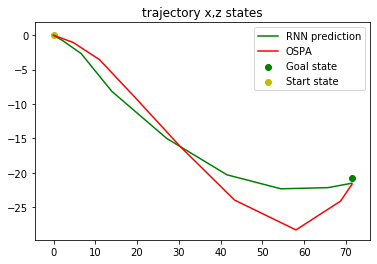

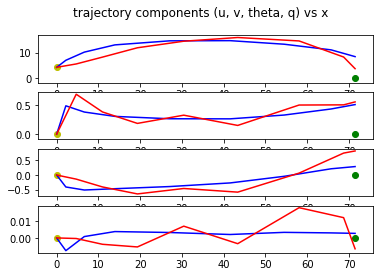

In [75]:
t_number = 78
plot_trajectory_2(trajectory_list, data_stats, t_number)

In [19]:
# raw_dataset = pd.read_csv("./data/ANN_results.csv")
# ANN_dataset = raw_dataset.copy()

# for index, row in ANN_dataset.iterrows():
#     CS_array =np.array(eval(row["states"]))
#     ANN_dataset["states"][index] = CS_array

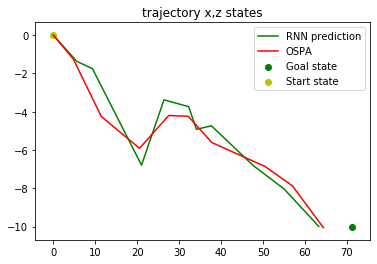

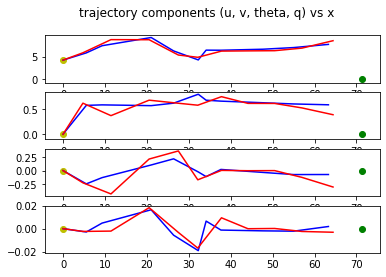

In [114]:
plot_trajectory(x_val_single_sequential, y_val_single_sequential, data_stats, 3)

In [80]:
validation_results= get_trajectory_results(x_val_single_sequential, y_val_single_sequential, data_stats)

In [83]:
results_summary(validation_results, metrics)

0.0


,all,result_end,result_error
time,0.475037,0.475037,NaN
distance_to_target,1.39928,1.39928,NaN
u_at_target,7.58886,7.58886,NaN
v_at_target,7.60216,7.60216,NaN
theta_at_target,0.200925,0.200925,NaN
mean_distance_in_trajectory,1.59412,1.59412,NaN
sqrt(trajectory MSE),4.9858,4.9858,NaN
k_value,0.350669,0.350669,NaN
